In [8]:
import pandas as pd
import numpy as np
from collections import defaultdict
import string

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

from sklearn.feature_extraction.text import CountVectorizer

In [9]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [12]:
train.shape

(7613, 5)

In [13]:
test.shape

(3263, 4)

#### training data

In [14]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### test data

In [15]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


#### distribution of values for target column in training set

In [16]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

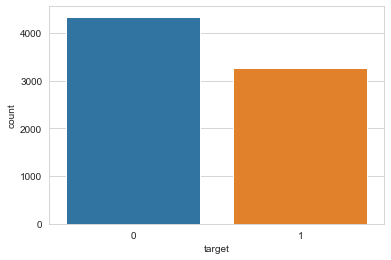

In [17]:
ax = sns.countplot(x=train['target'],data=train)

#### Exploring text data

/Users/teddyweaver/Documents/.venvs/MSDS_2020_Fall/case_studies/case1_snf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


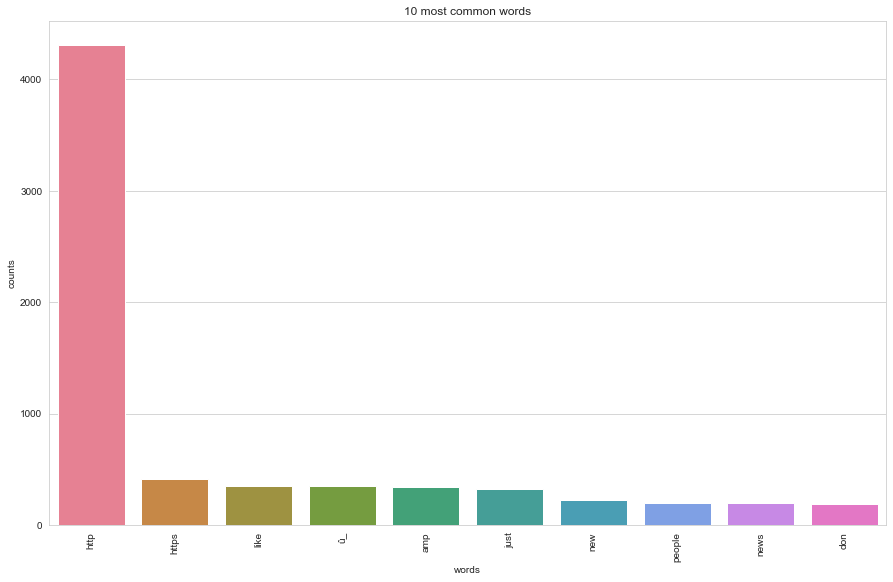

In [18]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(train['text'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)


#### Cleaning text data

In [19]:
# Load the regular expression library
import re

# Remove punctuation
train['text'] = train['text'].map(lambda x: re.sub('[,\.!?#]', '', x))

# Convert the titles to lowercase
train['text'] = train['text'].map(lambda x: x.lower())

# Print out the first rows of papers
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to 'shelter in place' are ...
3    13000 people receive wildfires evacuation orde...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [20]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [21]:
train = train[['id','text','target']]

In [22]:
test = test[['id','text']]

In [23]:
train.head()

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to 'shelter in place' are ...,1
3,6,13000 people receive wildfires evacuation orde...,1
4,7,just got sent this photo from ruby alaska as s...,1


In [24]:
test.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [25]:
#train.to_csv('cleaned_train.csv')

#### TF-IDF

In [26]:
## create separate dataframes for each of the target values
real_disaster = train.loc[train['target'] == 1]
real_disaster.head()

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to 'shelter in place' are ...,1
3,6,13000 people receive wildfires evacuation orde...,1
4,7,just got sent this photo from ruby alaska as s...,1


In [27]:
real_disaster.shape

(3271, 3)

In [28]:
fake_disaster = train.loc[train['target'] == 0]
fake_disaster.head()

,id,text,target
15,23,what's up man,0
16,24,i love fruits,0
17,25,summer is lovely,0
18,26,my car is so fast,0
19,28,what a goooooooaaaaaal,0


In [29]:
fake_disaster.shape

(4342, 3)

In [30]:
real_disaster['target'].value_counts()

1    3271
Name: target, dtype: int64

In [31]:
fake_disaster['target'].value_counts()

0    4342
Name: target, dtype: int64

In [32]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

In [34]:
# Define the vectorizer and specify the arguments
my_pattern = r'\b[^\d\W][^\d\W]+\b'
vect = TfidfVectorizer(ngram_range=(1,2), max_features=100, token_pattern=my_pattern, stop_words=ENGLISH_STOP_WORDS).fit(train.text)

# Transform the vectorizer
X_txt = vect.transform(train.text)
 
# Transform to a data frame and specify the column names
X=pd.DataFrame(X_txt.toarray(), columns=vect.get_feature_names())
print('Top 5 rows of the DataFrame: ', X.head())

Top 5 rows of the DataFrame:     accident  amp  army  attack  best  black  body  bomb  bomber  bombing  ...  \
0       0.0  0.0   0.0     0.0   0.0    0.0   0.0   0.0     0.0      0.0  ...   
1       0.0  0.0   0.0     0.0   0.0    0.0   0.0   0.0     0.0      0.0  ...   
2       0.0  0.0   0.0     0.0   0.0    0.0   0.0   0.0     0.0      0.0  ...   
3       0.0  0.0   0.0     0.0   0.0    0.0   0.0   0.0     0.0      0.0  ...   
4       0.0  0.0   0.0     0.0   0.0    0.0   0.0   0.0     0.0      0.0  ...   

   way  wildfire  work  world  year  years  youtube   û_  û_ http  ûªs  
0  0.0       0.0   0.0    0.0   0.0    0.0      0.0  0.0      0.0  0.0  
1  0.0       0.0   0.0    0.0   0.0    0.0      0.0  0.0      0.0  0.0  
2  0.0       0.0   0.0    0.0   0.0    0.0      0.0  0.0      0.0  0.0  
3  0.0       0.0   0.0    0.0   0.0    0.0      0.0  0.0      0.0  0.0  
4  0.0       0.0   0.0    0.0   0.0    0.0      0.0  0.0      0.0  0.0  

[5 rows x 100 columns]


In [35]:
# Import the required packages
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Build a BOW and tfidf vectorizers from the review column and with max of 100 features
vect1 = CountVectorizer(max_features=100).fit(train.text)
vect2 = TfidfVectorizer(max_features=100).fit(train.text)

# Transform the vectorizers
X1 = vect1.transform(train.text)
X2 = vect2.transform(train.text)
# Create DataFrames from the vectorizers
X_df1 = pd.DataFrame(X1.toarray(), columns=vect1.get_feature_names())
X_df2 = pd.DataFrame(X2.toarray(), columns=vect2.get_feature_names())
print('Top 5 rows, using BOW: \n', X_df1.head())
print('Top 5 rows using tfidf: \n', X_df2.head())

Top 5 rows, using BOW: 
    about  after  all  amp  an  and  are  as  at  back  ...  what  when  who  \
0      0      0    1    0   0    0    1   0   0     0  ...     0     0    0   
1      0      0    0    0   0    0    0   0   0     0  ...     0     0    0   
2      0      0    1    0   0    0    2   0   0     0  ...     0     0    0   
3      0      0    0    0   0    0    0   0   0     0  ...     0     0    0   
4      0      0    0    0   0    0    0   1   0     0  ...     0     0    0   

   why  will  with  would  you  your  û_  
0    0     0     0      0    0     0   0  
1    0     0     0      0    0     0   0  
2    0     0     0      0    0     0   0  
3    0     0     0      0    0     0   0  
4    0     0     0      0    0     0   0  

[5 rows x 100 columns]
Top 5 rows using tfidf: 
    about  after       all  amp   an  and       are        as   at  back  ...  \
0    0.0    0.0  0.477955  0.0  0.0  0.0  0.434588  0.000000  0.0   0.0  ...   
1    0.0    0.0  0.000000  0.0  

In [36]:
X_df1.head()

,about,after,all,amp,an,and,are,as,at,back,...,what,when,who,why,will,with,would,you,your,û_
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Top Words

#### Unigram

In [37]:
def clean_data(data):
    # Removing urls
    data = re.sub(r'https?://\S+|www\.\S+',' ', data)
    # Remove Punctutaions
    t = [w for w in data if w not in string.punctuation]
    data = ''.join(t)
    # Remove Stopwords
    t = [w for w in data.split() if w not in ENGLISH_STOP_WORDS]
    data = ' '.join(t)
    # Remove numbers from text'
    data = re.sub(r'\d+',' ', data)
    # Lowercasing the data
    data = data.lower()
    # Removing everthing other than alphabets
    data = re.sub('[^a-zA-Z]',' ', data)
    # Remove html tags
    data = re.sub(r'<.*?>',' ', data)
    # Removing whitespace characters
    data = re.sub(r'\s',' ',data)
    data = re.sub(r' +',' ',data)
    return data

train['text'] = train['text'].apply(lambda x: clean_data(x))
test['text'] = test['text'].apply(lambda x: clean_data(x))

<Figure size 432x288 with 0 Axes>

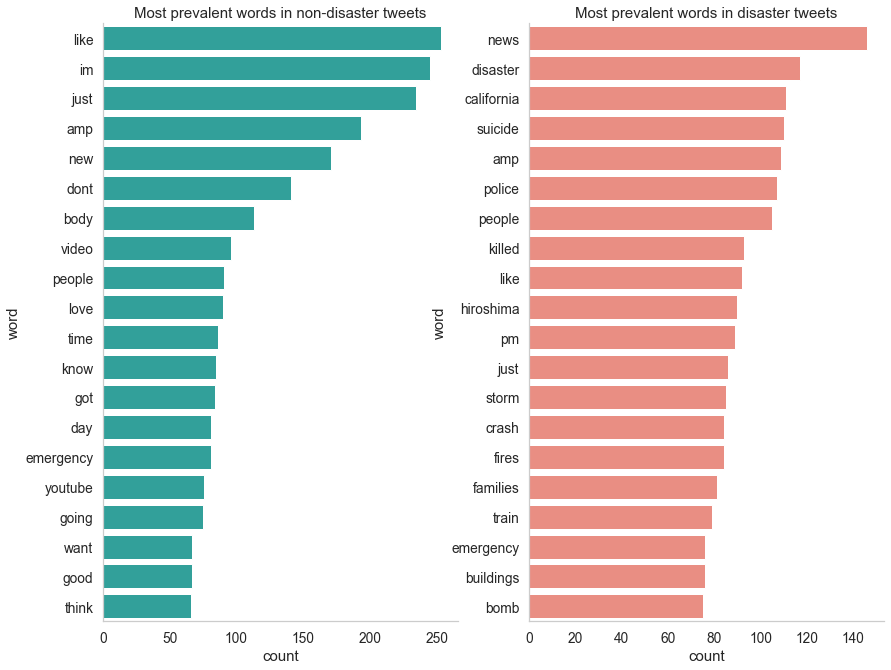

In [38]:
def get_top_n_words(corpus, ngram_range = (1,1), n= None):
    vec = CountVectorizer(ngram_range = ngram_range, stop_words = ENGLISH_STOP_WORDS).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    word_freq = [(word, sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    word_freq = sorted(word_freq, key = lambda x: x[1], reverse = True)
    return word_freq[:n]
neg_unigram = get_top_n_words(train[train['target']==1]['text'],(1,1),20)
pos_unigram = get_top_n_words(train[train['target']==0]['text'],(1,1),20)

df1 = pd.DataFrame(pos_unigram, columns = ['word','count'])
df2 = pd.DataFrame(neg_unigram, columns = ['word','count'])

plt.tight_layout()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,11))
sns.barplot(x = 'count' , y = 'word', data = df1, color = 'lightseagreen',orient = 'h',ax = ax1)
ax1.set_title('Most prevalent words in non-disaster tweets')
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.grid(False)
sns.barplot(x = 'count' , y = 'word', data = df2, color = 'salmon', orient = 'h',ax = ax2)
ax2.set_title('Most prevalent words in disaster tweets')
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.grid(False)

#### Bigram

<Figure size 432x288 with 0 Axes>

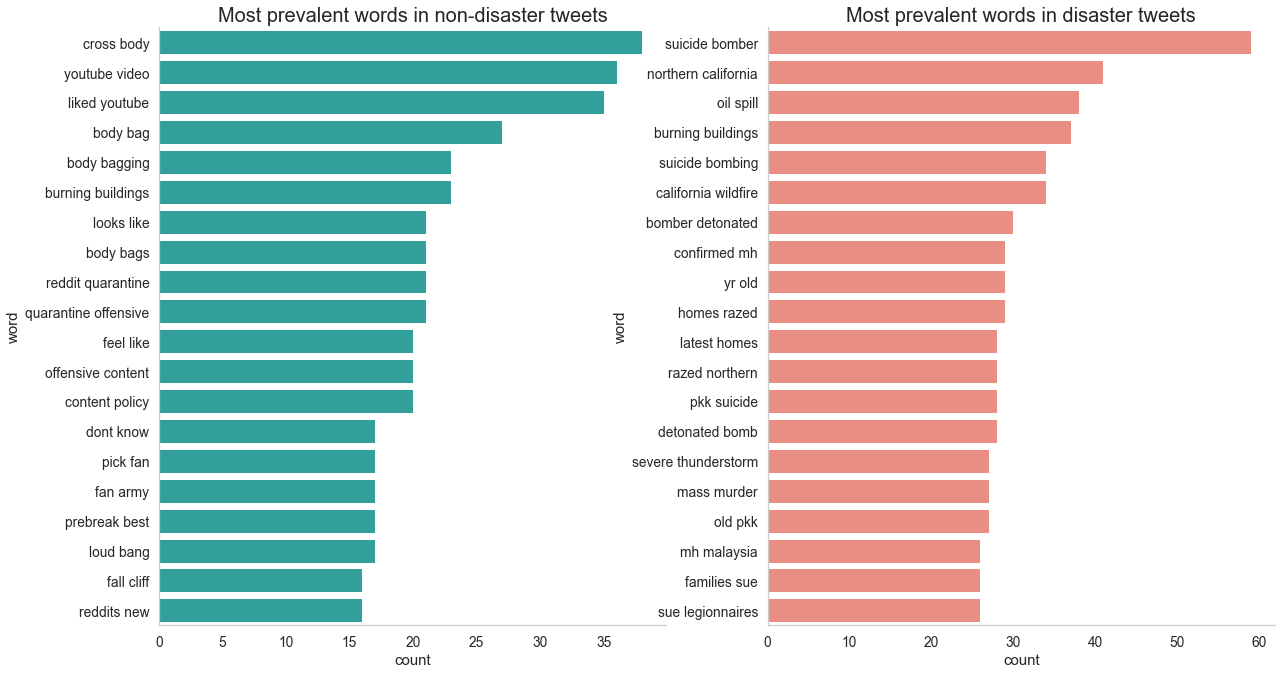

In [39]:
neg_unigram = get_top_n_words(train[train['target']==1]['text'],(2,2),20)
pos_unigram = get_top_n_words(train[train['target']==0]['text'],(2,2),20)

df1 = pd.DataFrame(pos_unigram, columns = ['word','count'])
df2 = pd.DataFrame(neg_unigram, columns = ['word','count'])

plt.tight_layout()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,11))
sns.barplot(x = 'count' , y = 'word', data = df1, color = 'lightseagreen', orient = 'h',ax = ax1)
ax1.set_title('Most prevalent words in non-disaster tweets', size = 20)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.grid(False)
sns.barplot(x = 'count' , y = 'word', data = df2, color = 'salmon', orient = 'h',ax = ax2)
ax2.set_title('Most prevalent words in disaster tweets', size = 20)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.grid(False)

#### Trigram

<Figure size 432x288 with 0 Axes>

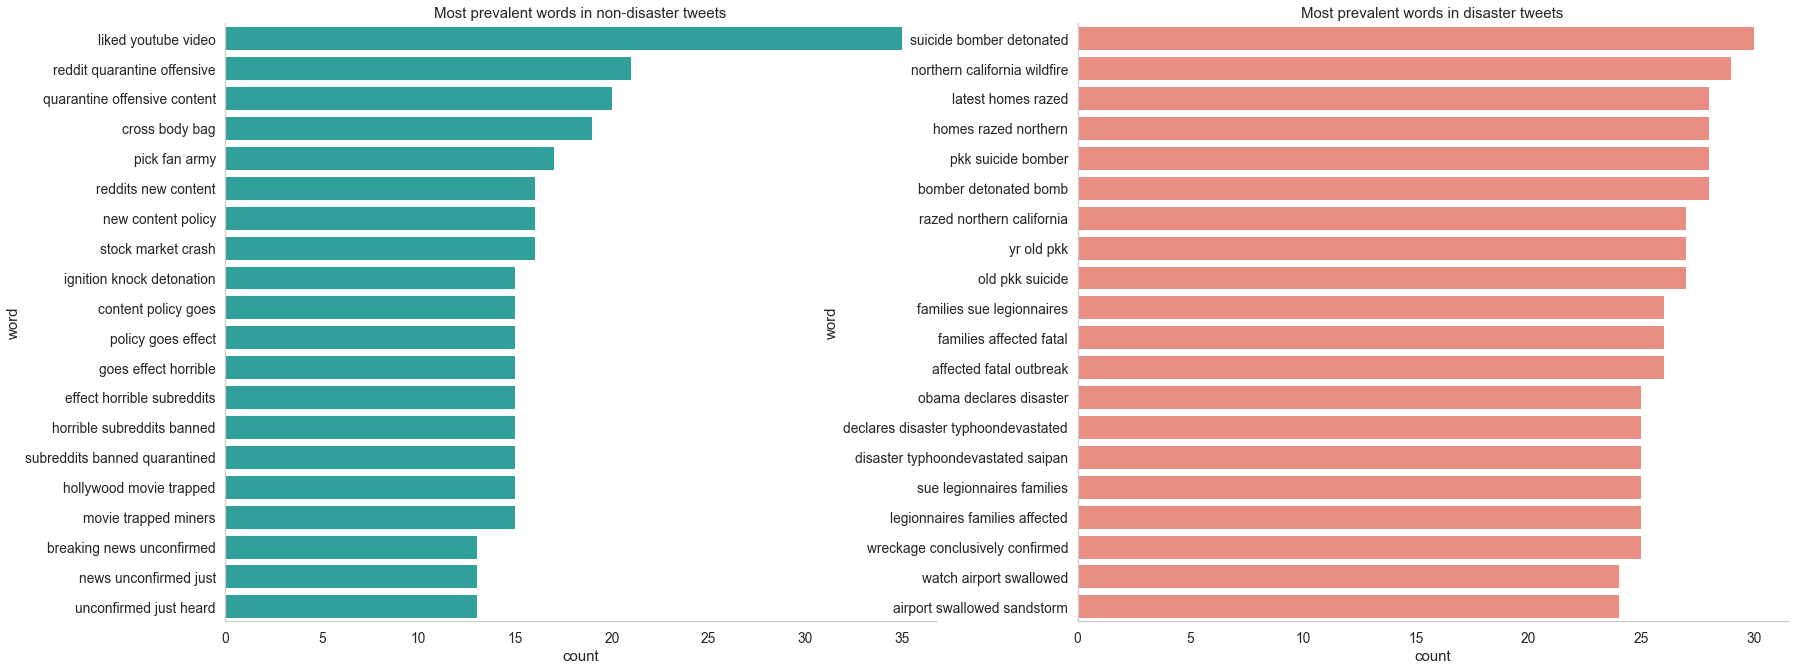

In [40]:
neg_unigram = get_top_n_words(train[train['target']==1]['text'],(3,3),20)
pos_unigram = get_top_n_words(train[train['target']==0]['text'],(3,3),20)

df1 = pd.DataFrame(pos_unigram, columns = ['word','count'])
df2 = pd.DataFrame(neg_unigram, columns = ['word','count'])

plt.tight_layout()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(28,11))
sns.barplot(x = 'count' , y = 'word', data = df1, color = 'lightseagreen',orient = 'h',ax = ax1)
ax1.set_title('Most prevalent words in non-disaster tweets')
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.grid(False)
sns.barplot(x = 'count' , y = 'word', data = df2, color = 'salmon', orient = 'h',ax = ax2)
ax2.set_title('Most prevalent words in disaster tweets')
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.grid(False)